## Домашнее задание по Автоматической обработке естественного языка №3

### Настя Шабаева, БКЛ181

### Установка SpaCy

In [2]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/en_core_web_sm
-->
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


###  Импорт всего необходимого

In [84]:
import re
import pandas as pd
from pprint import pprint


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import spacy

import nltk; nltk.download('stopwords')
from collections import Counter
import math
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Library/Frameworks/Pytho
[nltk_data]     n.framework/Versions/3.7/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Подготавливаем стоп-слова

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Скачиваем днные в таблицу

In [5]:
# скачиваем данные
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


### Обработка текста

Тексты из таблица добавляем в список, убираем из них почтовые адреса, лишние кавычки, всякие символы типа переноса строк меняем на пробелы.

In [6]:
data = df.content.values.tolist() # тексты из датафрейма кладем в список

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data] # убираем почтовые адреса

data = [re.sub('\s+', ' ', sent) for sent in data] # меняем все пробельные символы (новая строка и тд) на пробелы

data = [re.sub("\'", "", sent) for sent in data]# убираем одинарные кавычки

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


### Предложения -> слова

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### Добавляем биграммы и триграммы

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


###  Функции, чтобы убрать стоп-слова, чтобы создать биграммы и триграммы, лемматизировать слова и оставить только существительные, прилагательные, глаголы и наречия

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Применение описанных ранее функций

In [11]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


### Создаем словарь и корпус

In [12]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


 ### Обучаем модель (и печатаем топики, которые она выдаст)

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
lda_model.print_topics()

[(0,
  '0.175*"file" + 0.073*"entry" + 0.057*"error" + 0.053*"display" + 0.040*"program" + 0.030*"sun" + 0.025*"version" + 0.024*"cool" + 0.020*"output" + 0.020*"crash"'),
 (1,
  '0.032*"would" + 0.026*"say" + 0.022*"think" + 0.022*"people" + 0.020*"go" + 0.018*"know" + 0.016*"make" + 0.016*"see" + 0.014*"come" + 0.013*"thing"'),
 (2,
  '0.091*"evidence" + 0.048*"book" + 0.041*"faith" + 0.037*"reason" + 0.033*"exist" + 0.032*"claim" + 0.031*"religion" + 0.029*"believe" + 0.027*"christian" + 0.023*"church"'),
 (3,
  '0.541*"ax" + 0.054*"car" + 0.028*"player" + 0.014*"engine" + 0.009*"dealer" + 0.009*"mile" + 0.009*"expensive" + 0.009*"here" + 0.008*"extra" + 0.008*"specify"'),
 (4,
  '0.087*"belief" + 0.084*"internet" + 0.079*"atheist" + 0.061*"distribution" + 0.053*"wing" + 0.041*"atheism" + 0.038*"printer" + 0.034*"interface" + 0.026*"multiple" + 0.020*"thinking"'),
 (5,
  '0.088*"normal" + 0.072*"port" + 0.071*"mouse" + 0.053*"hole" + 0.036*"cap" + 0.034*"expansion" + 0.033*"default"

### Подсчет когерентности модели

In [15]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49288861569721343


### Попытка установить mallet

Неудачная, как выяснилось, из-за старой версии java на компьютере

In [71]:
import os

os.environ['MALLET_HOME'] = '/Users/macbook/mallet-2.0.8/bin/'

mallet_path = '/Users/macbook/mallet-2.0.8/bin/mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command '/Users/macbook/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/ft/yj1cv23d74zgpvxgg4m_f5fc0000gp/T/e829b3_corpus.txt --output /var/folders/ft/yj1cv23d74zgpvxgg4m_f5fc0000gp/T/e829b3_corpus.mallet' returned non-zero exit status 1.

### Функция, которая поможет определить оптимальное количество топиков

Алгоритм: создать несколько моделей с разным количеством топиков, посчитать для каждой когерентность и выбрать ту модель, где когерентность больше.

Для наглядности я решила не считать сразу максимальную когерентность в функции, а вывести график, показывающий как она меняется в зависимости от количества топиков

Результат мне показался немного странным: чем меньше топиков, тем точнее модель... Возможно, где-то есть моя ошибка, но я не понимаю где

Я решила не выбирать наименьшее число топиков. Для дальнейшей работы взяла 10.

In [81]:
def best_coherence(dictionary, corpus, texts):
    coherence_values = []
    model_list = []
    for topic_number in range(5,45,5):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=topic_number,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [82]:
model_list, coherence_values = best_coherence(id2word, corpus, texts)

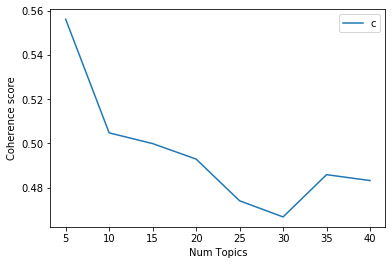

In [85]:
x = range(5, 45, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Обучаем новую модель и получаем её топики

In [86]:
lda_model_more_optimal = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [87]:
topics = lda_model_more_optimal.show_topics(num_topics=10, formatted=False)

### Подсчет основного топика для каждого текста

Проходим по каждому слову, по каждой теме, по всем словам в каждом топике, если слово из текста и слово из топика совпадают, добавляем вес слова в топике в счетчик. Завершив обход, смотрим по словарю-счетчику, какая тема в данном тексте имела больший вес, добавляем эту тему в список с основными темами

In [105]:
main_topics = []

for text in data_lemmatized:
    topics_text = {}
    for word in text:
        for topic in topics:
            for w in topic[1]:
                if w[0] == word:
                    if topic[0] in list(topics_text.keys()):
                        topics_text[topic[0]] += w[1]
                    else:
                        topics_text[topic[0]] = w[1]
    max_v = 0
    main_t = 0
    for i in topics_text.keys():
        if topics_text[i] > max_v:
            max_v = topics_text[i]
            main_t = i
    main_topics.append(main_t)

 На основе полученных данных строим таблицу

In [89]:
dict_dataframe = {'Main topic': main_topics, 'Text': data, 'Words from text': data_lemmatized}

df2 = pd.DataFrame(dict_dataframe)

In [90]:
df2

,Main topic,Text,Words from text
0,3,From: (wheres my thing) Subject: WHAT car is t...,"[where, thing, car, nntp_poste, host, park, li..."
1,7,From: (Guy Kuo) Subject: SI Clock Poll - Final...,"[si, poll, final, summary, final, call, si, cl..."
2,3,From: (Thomas E Willis) Subject: PB questions....,"[question, engineering, computer, network, dis..."
3,3,From: (Joe Green) Subject: Re: Weitek P9000 ? ...,"[division, line, host, amber, write, write, ar..."
4,3,From: (Jonathan McDowell) Subject: Re: Shuttle...,"[question, organization, smithsonian_astrophys..."
...,...,...,...
11309,3,From: (Jim Zisfein) Subject: Re: Migraines and...,"[migraine, city, ny_bis, reply, line, cheap, a..."
11310,7,From: Subject: Screen Death: Mac Plus/512 Line...,"[problem, screen, blank, sometimes, minor, phy..."
11311,4,From: (Will Estes) Subject: Mounting CPU Coole...,"[este, mount, case, organization, mail, group,..."
11312,5,From: (Steven Collins) Subject: Re: Sphere fro...,"[line, nntp_poste, host, article, write, boy, ..."


### Добавляем в список всю информацию из строк таблицы

In [91]:
list_for_groups = df2.values

### Формируем группы

Создаем слова, ключами которого будут номера тем, а в значениях будут находиться кортежи с тексами и лемматизированными словами из текстов

In [92]:
groups = {}

for row in list_for_groups:
    if row[0] not in list(groups.keys()):
        groups[row[0]] = []
    groups[row[0]].append((row[2],row[1]))
print(groups[0][0])

(['sigma_design', 'double', 'article', 'write', 'look', 'information', 'sigma_design', 'double', 'board', 'figure', 'work', 'sure', 'also', 'much', 'would', 'cost', 'have', 'board', 'year', 'work', 'due', 'licensing', 'problem', 'technology', 'owner', 'board', 'compression', 'technology', 'be', 'write', 'memory', 'have', 'lose', 'reference', 'correct', 'be', 'wrong', 'use', 'board', 'have', 'problem', 'file', 'icon', 'lose', 'hard', 'say', 'board', 'fault', 'else', 'however', 'decompress', 'troubled', 'file', 'recompress', 'board', 'icon', 'usually', 'reappear', 'mention', 'licensing', 'problem', 'expansion', 'utility', 'expand', 'compress', 'file', 'board', 'instal', 'stac', 'product', 'seem', 'unlikely', 'hole', 'board', 'fix', 'sad', 'make', 'reluctant', 'buy', 'product', 'be', 'stinky', 's', 'competition', 'compute', 'office', 'phone', 'email'], 'From: (Stan Kerr) Subject: Re: Sigma Designs Double up?? Article-I.D.: ux1.C52u8x.B62 Organization: University of Illinois at Urbana Line

### Функции по подсчету IDF, TF  и TF_IDF

In [93]:
def computeIDF(documents):
    N = len(documents)
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents: 
        for word, val in document.items():
            if val > 0:
                if word not in idfDict.keys():
                    idfDict[word] = 0
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [94]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [95]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

### Функция для обработки групп

В неё поступает словарь из групп и номер группы, которая должна сейчас обрабатываться. 

В ней мы проходим по всем текстам группы, создаем их Counter, чтобы понять сколько раз слово встречалось в своем тексте, список этих Counter (точнее словарей из них) подаём в функцию, считающую IDFs, затем идем по-очереди по всем текстам, считаем TF, TF_IDF и находим 5 слов с самым большим TF_IDF, создаем из них список.

В конце  создаем кортеж из номера основного топика, самого текста и 5 ключевых слов, кортежи для каждого текста собираем в список. Этот список и возвращает функция.

In [96]:
def coun_tfidf(groups, group_number):
    group = list(groups.values())[group_number]
    list_of_counters = []
    final_list = []
    for text in group:
        list_of_counters.append(dict(Counter(text[0])))
    idfs_group = computeIDF(list_of_counters)
    for text in group:
        TF = computeTF(dict(Counter(text[0])), text[0])
        TFIDF = computeTFIDF(TF, idfs_group)
        help_list = []
        for i in Counter(TFIDF).most_common(5):
            help_list.append(i[0])
        final_tuple = (group_number, text[1], help_list)
        final_list.append(final_tuple)
    return final_list

### Запускаем функцию для вех групп, формируем финальный список кортежей

In [97]:
final_list_for_df = []
for i in groups:
    final_list_for_df.extend(coun_tfidf(groups, i))
print(final_list_for_df[0])

(3, 'From: (Stan Kerr) Subject: Re: Sigma Designs Double up?? Article-I.D.: ux1.C52u8x.B62 Organization: University of Illinois at Urbana Lines: 29 (Joseph A. Pellettiere) writes: > I am looking for any information about the Sigma Designs > double up board. All I can figure out is that it is a > hardware compression board that works with AutoDoubler, but > I am not sure about this. Also how much would one cost? Ive had the board for over a year, and it does work with Diskdoubler, but not with Autodoubler, due to a licensing problem with Stac Technologies, the owners of the boards compression technology. (Im writing this from memory; Ive lost the reference. Please correct me if Im wrong.) Using the board, Ive had problems with file icons being lost, but its hard to say whether its the boards fault or something else; however, if I decompress the troubled file and recompress it without the board, the icon usually reappears. Because of the above mentioned licensing problem, the freeware ex

Из полученного списка кортежей делаем словарь, и по нему строим финальную таблицу

In [98]:
main_topic_number = []
this_text = []
key_words = []

for inf in final_list_for_df:
    main_topic_number.append(inf[0])
    this_text.append(inf[1])
    key_words.append(inf[2])

dict_df_final = {'Main Topic': main_topic_number, 
                 'Text': this_text,
                 'Key words': key_words}

df_final = pd.DataFrame(dict_df_final)

In [99]:
df_final

,Main Topic,Text,Key words
0,3,From: (Stan Kerr) Subject: Re: Sigma Designs D...,"[board, sigma_design, licensing, double, lose]"
1,3,From: (Allen B) Subject: Re: TIFF: philosophic...,"[tiff, complexity, inability, image, significa..."
2,3,From: (Ann Marie Barden) Subject: X-Terminal C...,"[ncd, boot, terminal, control, access]"
3,3,From: (Chris Syphers) Subject: Re: ?? DOS font...,"[font, uafhp, uark, funky, hpoe]"
4,3,From: (Sam Latonia) Subject: Re: Need phone nu...,"[western_digital, love, crash, phone, copy]"
...,...,...,...
11309,9,From: (Marty Leisner 71348 ) Subject: Intraven...,"[intravenous, antibiotic, give, leisner, xerox]"
11310,9,From: (Tony Alicea) Subject: Re: Rosicrucian O...,"[name, group, correct, rosicrucian, even]"
11311,9,From: (Thyagi Morgoth NagaSiva) Subject: Re: O...,"[metaphysical, love, word, true, apparently]"
11312,9,From: ( ) Subject: horse breeding and saling R...,"[horse, firm, class, breeding, sale]"
